# Imports

In [1]:
import utils.data as data
import utils.sub_architectures as sub_architectures
from IPython.display import clear_output

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


# Do Autoencoder

In [3]:
#train_data = data.GridCutoutDataset(cutout_shape=64, mode = "train")
#val_data = data.GridCutoutDataset(cutout_shape=64,mode = "validation")
val_data = data.RandomSamplingGridCutoutDataset(preprocess_image_options = {
            "use_mask": True,
            "equalize_hist": False,
            "crop_black": True,
            "match_histogram": False
        }, crop_shape=(128,128), resample_image_every_n_draws=50)

In [5]:
#Prepare data loaders
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, num_workers=0, shuffle=True)
train_loader = val_loader

In [6]:
model = sub_architectures.ConvolutionalAutoencoderV2().to(device)

In [7]:
#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2, cooldown=1, verbose=True)

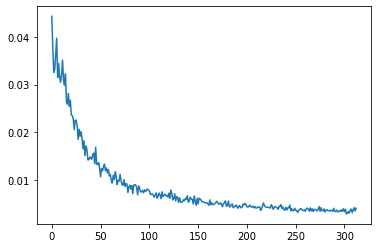

Loss After 1 Epochs: 0.008506836

In [8]:
# Epochs
n_epochs = 25
train_loss = []

# Training
model.train()
for epoch in range(n_epochs):
    epoch_losses = []
    for x in train_loader:
        x = x.to(device)
        outputs = model(x)

        loss = criterion(outputs, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.detach().cpu().numpy())

    clear_output(wait=True)
    train_loss.extend(epoch_losses)
    lr_schedule.step(np.mean(epoch_losses))
    
    plt.plot(range(len(train_loss)), train_loss)
    plt.show()
    print(f"\rLoss After {epoch+1} Epochs: "+str(np.mean(epoch_losses)), end="")
    if np.mean(epoch_losses) < 0.01:
        break


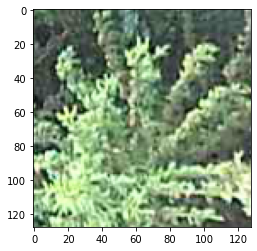

In [27]:
plt.imshow(np.transpose(val_data[2], (1,2,0)))
plt.show()

In [10]:
model.save(filename="no_histogram_128_trained")

Paramters saved to file 'saved_models/ConvolutionalAutoencoderV2/no_histogram_128_trained'.


In [10]:
#test_data = data.GridCutoutDataset(cutout_shape=64,mode = "test")
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0, shuffle=True)

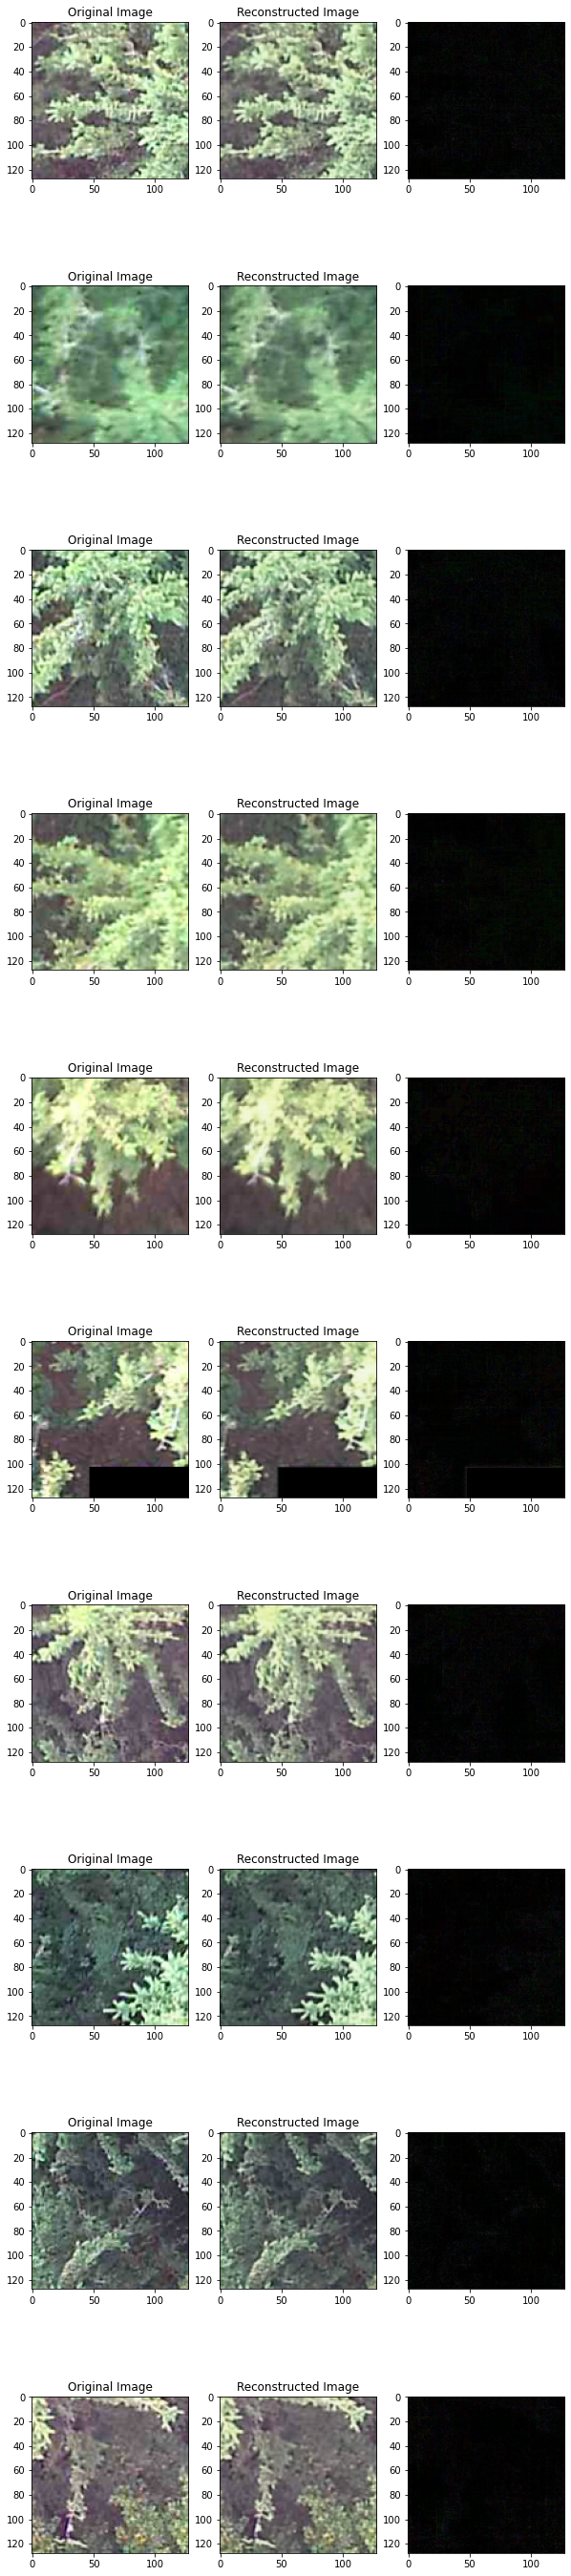

In [9]:
images = next(iter(val_loader))
numpy_images = images.numpy()

#Sample outputs
model.eval()
numpy_output = model(images.to(device)).detach().cpu().numpy()

numpy_images = np.transpose(numpy_images, (0, 2, 3, 1))
numpy_output = np.transpose(numpy_output, (0, 2, 3, 1))



show_n_images = 10

fig, axes = plt.subplots(nrows=show_n_images, ncols=3, figsize=(10,5*show_n_images))
for idx in range(show_n_images):
    axes[idx, 0].imshow(numpy_images[idx])
    axes[idx,0].set_title("Original Image")
    axes[idx, 1].set_title("Reconstructed Image")
    axes[idx, 1].imshow(numpy_output[idx])
    axes[idx, 1].set_title("Reconstructed Image")

    axes[idx, 2].imshow(abs(numpy_images[idx]-numpy_output[idx]))

plt.show()


### try out using some mathod on the code dim

In [12]:
model.eval()

codings =  []
for mini_batch in val_loader:
    
    codings.append(model.forward(mini_batch.to(device), True)[1].detach().cpu().numpy())

In [18]:
cat_cod = np.concatenate(codings)

meaned = np.mean(cat_cod, axis=(2,3))

In [28]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [30]:
pca = PCA(n_components=2)
kmeans = KMeans(5)

In [36]:
y = kmeans.fit(meaned).labels_

transformed = pca.fit_transform(meaned)

In [35]:
kmeans.labels_.shape

(10000,)

In [38]:
y[0]

3

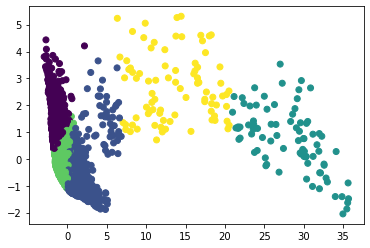

In [39]:
plt.scatter(transformed[:,0], transformed[:,1], c=y)

# Try out from MultiViewTemporalSample directly

In [5]:
dataset = data.MultiViewTemporalDataset(mode = "validation", apply_mask  = True)

autoencoder = sub_architectures.ConvolutionalAutoencoderV1().to(device)
state_dict = torch.load("saved_models/ConvolutionalAutoencoderV1/2021-12-06_00-00-19.pt")
autoencoder.load_state_dict(state_dict)

sample = dataset[2]

In [7]:
photo = sample.photos[0][4]

In [68]:
d = np.arange(16*3).reshape(1,4,4,3)
print(d)

print(np.transpose(d, (0, 3, 1, 2)))


[[[[ 0  1  2]
   [ 3  4  5]
   [ 6  7  8]
   [ 9 10 11]]

  [[12 13 14]
   [15 16 17]
   [18 19 20]
   [21 22 23]]

  [[24 25 26]
   [27 28 29]
   [30 31 32]
   [33 34 35]]

  [[36 37 38]
   [39 40 41]
   [42 43 44]
   [45 46 47]]]]
[[[[ 0  3  6  9]
   [12 15 18 21]
   [24 27 30 33]
   [36 39 42 45]]

  [[ 1  4  7 10]
   [13 16 19 22]
   [25 28 31 34]
   [37 40 43 46]]

  [[ 2  5  8 11]
   [14 17 20 23]
   [26 29 32 35]
   [38 41 44 47]]]]


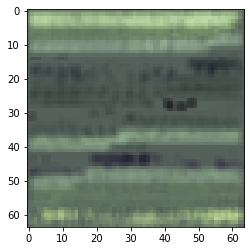

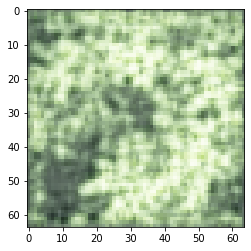

In [16]:
device = "cuda"

random_cut_photo = photo[500:500+64, 500:500+64]
autoencoder = autoencoder.eval().to(device)
autoencoder = autoencoder.eval()

t2 = random_cut_photo.reshape(1, *random_cut_photo.shape)
t2 = np.transpose(t2, (0, 3, 1, 2)).astype(np.float32) / 255
t2 = torch.tensor(t2, device=device)
t2_r = autoencoder(t2*1.0001).detach().cpu().numpy()
t2_r = np.transpose((t2_r * 255).astype(np.uint8), (0, 2, 3, 1))
plt.imshow(t2_r[0])
plt.show()

t1 = np.transpose(random_cut_photo, (2, 0, 1)).astype(np.float32) / 255
t1 = t1.reshape(1, *t1.shape)
t1 = torch.tensor(t1, device=device)
t1_r = autoencoder(t1*1.0001).detach().cpu().numpy()
t1_r = np.transpose((t1_r * 255).astype(np.uint8), (0, 2, 3, 1))
plt.imshow(t1_r[0])
plt.show()



In [109]:
np.allclose(t1_r, t2_r)

True

In [55]:
transformed_grid_images = (np.transpose(grid_images, (0, 3, 1, 2)).astype(np.float32) / 255)
torch_grid_images = torch.tensor(transformed_grid_images, device=device)
reconstructed_grid_images = autoencoder(torch_grid_images).detach().cpu().numpy()

reconstructed_grid_images = np.transpose((reconstructed_grid_images * 255).astype(np.int16), (0, 2, 3, 1))

In [87]:
rc = autoencoder(torch.tensor(t1).to(device)).detach().cpu().numpy()
reconstructed_grid_images = np.transpose((rc * 255).astype(np.uint8), (0, 2, 3, 1))

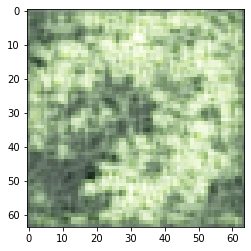

In [88]:
plt.imshow(reconstructed_grid_images[0])

# Old Code

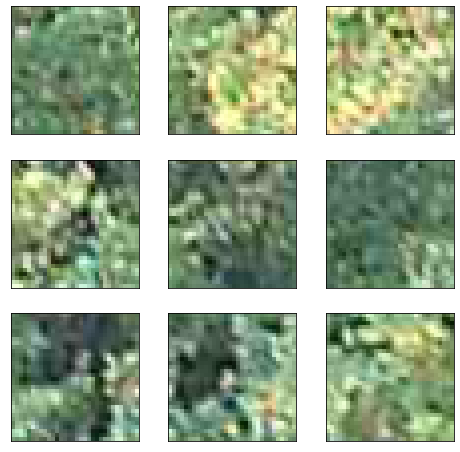

In [6]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img=img
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Obtain one batch of training images
dataiter = iter(train_loader)
for i in range(121):
    images = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [7]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x


#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [ ]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [13]:
#Epochs
n_updates = 6000

train_loss = 0.0
i=0

#Training
for data in train_loader:
    images = data
    images = images.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, images)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*images.size(0)
    
    if i%1000==0:
        print(i)
    if i>n_updates:
        break;
    i+=1

train_loss = train_loss/n_updates
print('N_updates: {} \tTraining Loss: {:.6f}'.format(n_updates, train_loss))

0
1000
2000
3000
4000
5000
6000
N_updates: 6000 	Training Loss: 12.088685


Original Images


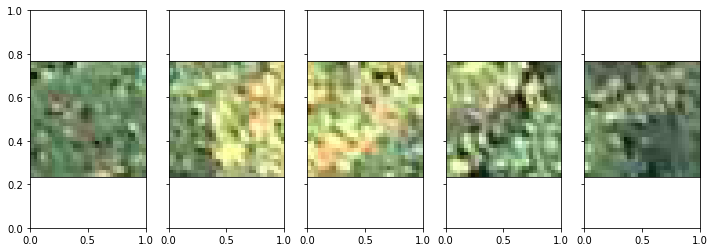

Reconstructed Images


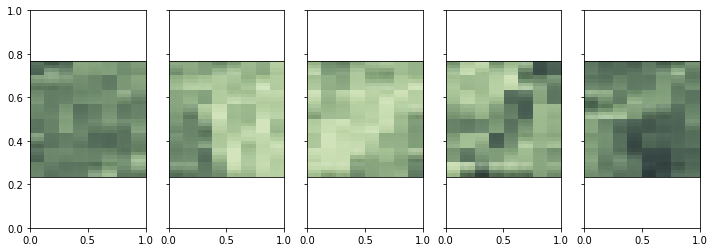

In [15]:
#Batch of test images
batch_size=32

dataiter = iter(val_loader)
for i in range(121):
    images = dataiter.next()

#Sample outputs
output = model(images)
images = images.numpy()

output = output.view(batch_size, 3, 32, 32)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 